In [1]:
# !wget -O train.py https://raw.githubusercontent.com/SaidAyad73/AdaIN/refs/heads/main/train.py
# !wget -O utils.py https://raw.githubusercontent.com/SaidAyad73/AdaIN/refs/heads/main/utils.py
# !wget -O train_lit.py https://raw.githubusercontent.com/SaidAyad73/AdaIN/refs/heads/main/train_lit.py


In [2]:
# !pip install lightning 

In [3]:
# !python train_lit.py --lr 0.0001 --epochs 10 --batch_size 16 --start_factor 1.0 --end_factor 0.1 --style_weight 14 -- checkpoint v1.ckpt --devices 2 --val_interval .25

In [4]:
# from utils import *
import utils

import lightning as L
import importlib
import torch
from torch import nn
from itertools import cycle
import matplotlib.pyplot as plt
import shutil
from PIL import Image
from torch.utils.data import Dataset

In [5]:
# importlib.reload(utils)
# import utils

class DataZip(Dataset):
    
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __len__(self):
        return len(self.dataset1)

    def __getitem__(self, idx):
        item1 = self.dataset1[idx]
        item2 = self.dataset2[idx]
        return item1, item2

In [6]:
from torchvision.transforms import ToTensor, Lambda, RandomCrop
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import ImagesDataset
import os
import random
transform = [
    ToTensor(),
    Lambda(utils.resizeWithAspectRatio),
    RandomCrop((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
]
images_train_path = '/kaggle/working/image_train'
images_test_path = '/kaggle/working/test_path'
images_val_path = '/kaggle/working/test_path'
styles_train_path = '/kaggle/working/style_path'
images_train_paths = [os.path.join(root, file) for root,dirs,files in os.walk(images_train_path) for file in files if file.endswith(('png','jpg','jpeg'))]
images_val_paths = [os.path.join(root, file) for root,dirs,files in os.walk(images_val_path) for file in files if file.endswith(('png','jpg','jpeg'))]
images_test_paths = [os.path.join(root, file) for root,dirs,files in os.walk(images_test_path) for file in files if file.endswith(('png','jpg','jpeg'))]
styles_train_paths_min = [os.path.join(root, file) for root,dirs,files in os.walk(styles_train_path) for file in files if file.endswith(('png','jpg','jpeg'))]
random.shuffle(styles_train_paths_min)
random.shuffle(images_train_paths)
styles_train_path = styles_train_paths_min * 5
styles_train_paths = styles_train_path[:len(images_train_paths)]
style_val_paths = styles_train_paths_min[:len(images_val_paths)]

train_dataset = ImagesDataset(images_train_paths,transform=transform)
val_dataset = ImagesDataset(images_val_paths,transform=transform)
test_dataset = ImagesDataset(images_test_paths,transform=transform)
train_styles_dataset = ImagesDataset(styles_train_paths,transform=transform) # using train images as styles
val_styles_dataset = ImagesDataset(style_val_paths,transform=transform)
train_dataset = DataZip(train_dataset, train_styles_dataset)
val_dataset = DataZip(val_dataset, val_styles_dataset)
test_dataset = DataZip(test_dataset,val_styles_dataset)
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Style train dataset size: {len(train_styles_dataset)}')
print(f'Style validation dataset size: {len(val_styles_dataset)}')

# train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4,pin_memory=True,drop_last=True)
# val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=4,pin_memory=True,drop_last=True)
# test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=4,pin_memory=True,drop_last=True)
# styles_loader = DataLoader(styles_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4,pin_memory=True,drop_last=True)

Train dataset size: 0
Validation dataset size: 0
Test dataset size: 0
Style train dataset size: 0
Style validation dataset size: 0


In [ ]:
"""
todo
scheduling
loging
vis
"""
import random

from lightning.pytorch.callbacks import TQDMProgressBar

class AdaINLitModule(L.LightningModule):
    def __init__(self,encoder,decoder,lr,scheduler = None,scheduler_args = None,content_weight = 1.0, style_weight = 1.0,checkpoint = None): #check if you need to compile
        """
        encoder: nn.Module not compiled
        decoder: nn.Module not compiled
        """
        super().__init__()
        for param in encoder.parameters():
            param.requires_grad = False
        for i, layer in enumerate(encoder):
            if isinstance(layer, nn.ReLU):
                encoder[i] = nn.ReLU(inplace=False)
        
        # encoder = torch.compile(encoder)
        # decoder = torch.compile(decoder)
        self.encoder = encoder
        self.decoder = decoder
        self.content_weight = content_weight
        self.style_weight = style_weight
        
        self.model = utils.AdaINModel(encoder,decoder,utils.AdaIN(1e-5))
        # self.model = torch.compile(self.model)
        
        self.content_loss = utils.ContentLoss(encoder=self.encoder)
        self.style_loss = utils.StyleLoss(encoder=self.encoder)
        # self.content_loss = torch.compile(self.content_loss)
        # self.style_loss = torch.compile(self.style_loss)
        
        self.lr = lr
        self.scheduler = scheduler
        self.scheduler_args = scheduler_args if scheduler_args is not None else {}
        # self.train_loss = [] # content, style, total
        # self.val_loss = [] # content, style, total

        if checkpoint is not None:
            self.model.load_state_dict(torch.load(checkpoint))
            
    def forward(self,content,style):
        return self.model(content,style)
    
    def training_step(self,batch,batch_idx):
        content,style = batch
        generated = self.model(content,style)
        y_gen,ada_out = generated['x_gen'],generated['ada_out']
        c_loss = self.content_loss(y_gen,ada_out)
        s_loss = self.style_loss(y_gen,style)
        loss = c_loss * self.content_weight + s_loss * self.style_weight
        # self.train_loss.append((c_loss.item(),s_loss.item(),loss.item()))
        self.log(f'train_loss',loss,prog_bar=True)
        self.log(f'train_content_loss * {self.content_weight} ',c_loss*self.content_weight,prog_bar=True)
        self.log(f'train_style_loss * {self.style_weight} ',s_loss*self.style_weight,prog_bar=True)
        return loss
    
    def validation_step(self,batch,batch_idx):
        content,style = batch
        generated = self.model(content,style)
        y_gen,ada_out = generated['x_gen'],generated['ada_out']
        c_loss = self.content_loss(y_gen,ada_out)
        s_loss = self.style_loss(y_gen,style)
        loss = c_loss * self.content_weight + s_loss * self.style_weight
        # self.val_loss.append((c_loss.item(),s_loss.item(),loss.item()))
        self.log('val_loss',loss,prog_bar=True,sync_dist=True)
        self.log('val_content_loss',c_loss,prog_bar=True,sync_dist=True)
        self.log('val_style_loss',s_loss,prog_bar=True,sync_dist=True)
        return loss
    
    def test_step(self,batch,batch_idx):
        content,style = batch
        generated = self.model(content,style)
        y_gen,ada_out = generated['x_gen'],generated['ada_out']
        c_loss = self.content_loss(y_gen,ada_out)
        s_loss = self.style_loss(y_gen,style)
        loss = c_loss * self.content_weight + s_loss * self.style_weight
        self.log('test_loss',loss)
        
        return loss
    
    def configure_optimizers(self):
        print('Configuring optimizers...')
        optimizer = torch.optim.Adam(self.model.parameters(),lr=self.lr,weight_decay=0.01)
        if self.scheduler is None:
            return optimizer
        return [optimizer],[self.scheduler(optimizer,**self.scheduler_args)]

    def setup(self, stage: str):

        if stage == "fit":
            print(f"Compiling model on rank {self.global_rank}...")
            self.model = torch.compile(self.model)
            self.content_loss = torch.compile(self.content_loss)
            self.style_loss = torch.compile(self.style_loss)
    
    def train_dataloader(self):
        train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4,pin_memory=True,drop_last=True)
        return train_loader
    def val_dataloader(self):
        val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=4,pin_memory=True,drop_last=True)
        return val_loader
BATCH_SIZE = 32
seed = 42
lr = 1e-4
start_factor = 1.0
end_factor = 0.98
scheduler = torch.optim.lr_scheduler.LinearLR
content_weight = 1.0
style_weight = 20.0
checkpoint =  None
encoder = utils.get_vgg_encoder()
decoder = utils.get_decoder()
bar = TQDMProgressBar(refresh_rate=2)
lr_monitor = L.pytorch.callbacks.LearningRateMonitor(logging_interval='step')
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(monitor='val_loss',dirpath='./checkpoints',filename='adain-{epoch:02d}-{val_loss:.2f}',save_top_k=3,mode='min',save_last=True,every_n_epochs=1)
# trainer = L.Trainer(devices=2,val_check_interval=int(.25*len(train_dataset)//BATCH_SIZE),max_epochs=30,enable_progress_bar=True,accumulate_grad_batches=1,reload_dataloaders_every_n_epochs=1,callbacks=[lr_monitor,checkpoint_callback,bar])
model = AdaINLitModule(encoder,decoder,lr,scheduler,scheduler_args={'start_factor': start_factor, 'end_factor': end_factor},content_weight=content_weight,style_weight=style_weight,checkpoint=checkpoint)
# state_dict = torch.load('./checkpoints/adain-epoch=17-val_loss=24.27.ckpt',map_location='cpu')['state_dict']
new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

KeyError: 'state_dict'

In [9]:
transform_img = [
    ToTensor(),
    transforms.Resize(256, antialias=True),   # keep ratio, shortest side = 256
    transforms.CenterCrop(224),               # crop to fixed size
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
]

transform_img = transforms.Compose(transform_img)
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Undo ImageNet normalization for (B,C,H,W) or (C,H,W) tensors."""
    mean = torch.tensor(mean, device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(1, 3, 1, 1)
    
    if tensor.ndim == 3:
        mean = mean.squeeze(0)
        std = std.squeeze(0)
    
    return tensor * std + mean

In [ ]:
imgs = ['/kaggle/working/test-data/'+f for f in os.listdir('/kaggle/working/test-data') if f.endswith(('png','jpg','jpeg')) and f.startswith('con')]
# styles = ['/kaggle/working/test-data/'+f for f in os.listdir('/kaggle/working/test-data') if f.endswith(('png','jpg','jpeg')) and not f.startswith('con')]
styles = ['/kaggle/working/test-data/d.jpg','/kaggle/working/test-data/images.jpg','/kaggle/working/test-data/neural_style_transfer_5_1.jpg','/kaggle/working/test-data/s1.jpg']

In [20]:

state_dict = torch.load('model.pt')
encoder = utils.get_vgg_encoder()
decoder = utils.get_decoder()

model = utils.AdaINModel(encoder, decoder,utils.AdaIN(.000001))
model.load_state_dict(state_dict)
# model = torch.compile(model)
model.eval()

AdaINModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [16]:
model

OptimizedModule(
  (_orig_mod): AdaINModel(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [22]:
from torchvision.transforms import functional as F
import numpy as np
def process_images(content_image, style_image, model):
    # Get content dimensions in (H, W)
    content_h, content_w = content_image.size[1], content_image.size[0]
    print(f"Using content shape: ({content_h}, {content_w})")

    # Define normalization transform
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    # Convert both to tensors
    content_tensor = F.to_tensor(content_image)
    style_tensor = F.to_tensor(style_image)

    # Resize style to match content size (preserving aspect ratio)
    style_tensor = F.resize(style_tensor, size=[content_h, content_w], antialias=True)

    # Add batch dim + normalize
    content_tensor = normalize(content_tensor).unsqueeze(0)
    style_tensor = normalize(style_tensor).unsqueeze(0)
    print('generating')
    with torch.no_grad():
        generated = model(content_tensor, style_tensor)
        y_gen = generated["x_gen"]
        y_gen = denormalize(y_gen)
        y_gen = y_gen.permute(0, 2, 3, 1).cpu().squeeze()
        y_gen = torch.clamp(y_gen, 0, 1)
        y_gen = (y_gen.numpy() * 255).astype(np.uint8)
    print('original shape', (content_h, content_w))
    print('y_gen shape',y_gen.shape[-2],y_gen.shape[-3])
    return y_gen

content_path = 'content/content.jpg'
style_path = 'styles/with_lighting.jpeg'
content = Image.open(content_path).convert('RGB')
style = Image.open(style_path).convert('RGB')
image_gan = process_images(content, style, model)
# plt.imshow(image_gan)

Using content shape: (1280, 721)
generating
original shape (1280, 721)
y_gen shape 720 1280


In [36]:
imgs = [f'./content/{img}' for img in os.listdir('./content')]
styles = [f'./styles/{style}' for style in os.listdir('./styles')]

In [32]:
imgs

['./content/2d74cb0c1c31060a5f7ec3bae5e22cf0.jpg',
 './content/867a5e1dd74ccc04c9baa2064695a75d.jpg',
 './content/a57803e6f37f73382bf89b007a4b5954.jpg',
 './content/download.jpg']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52102995..1.3720716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.048967242..1.3937658].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.555418..1.3209842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.032776177..0.83097297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20888391..1.4191246].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60284436..1.6360227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0

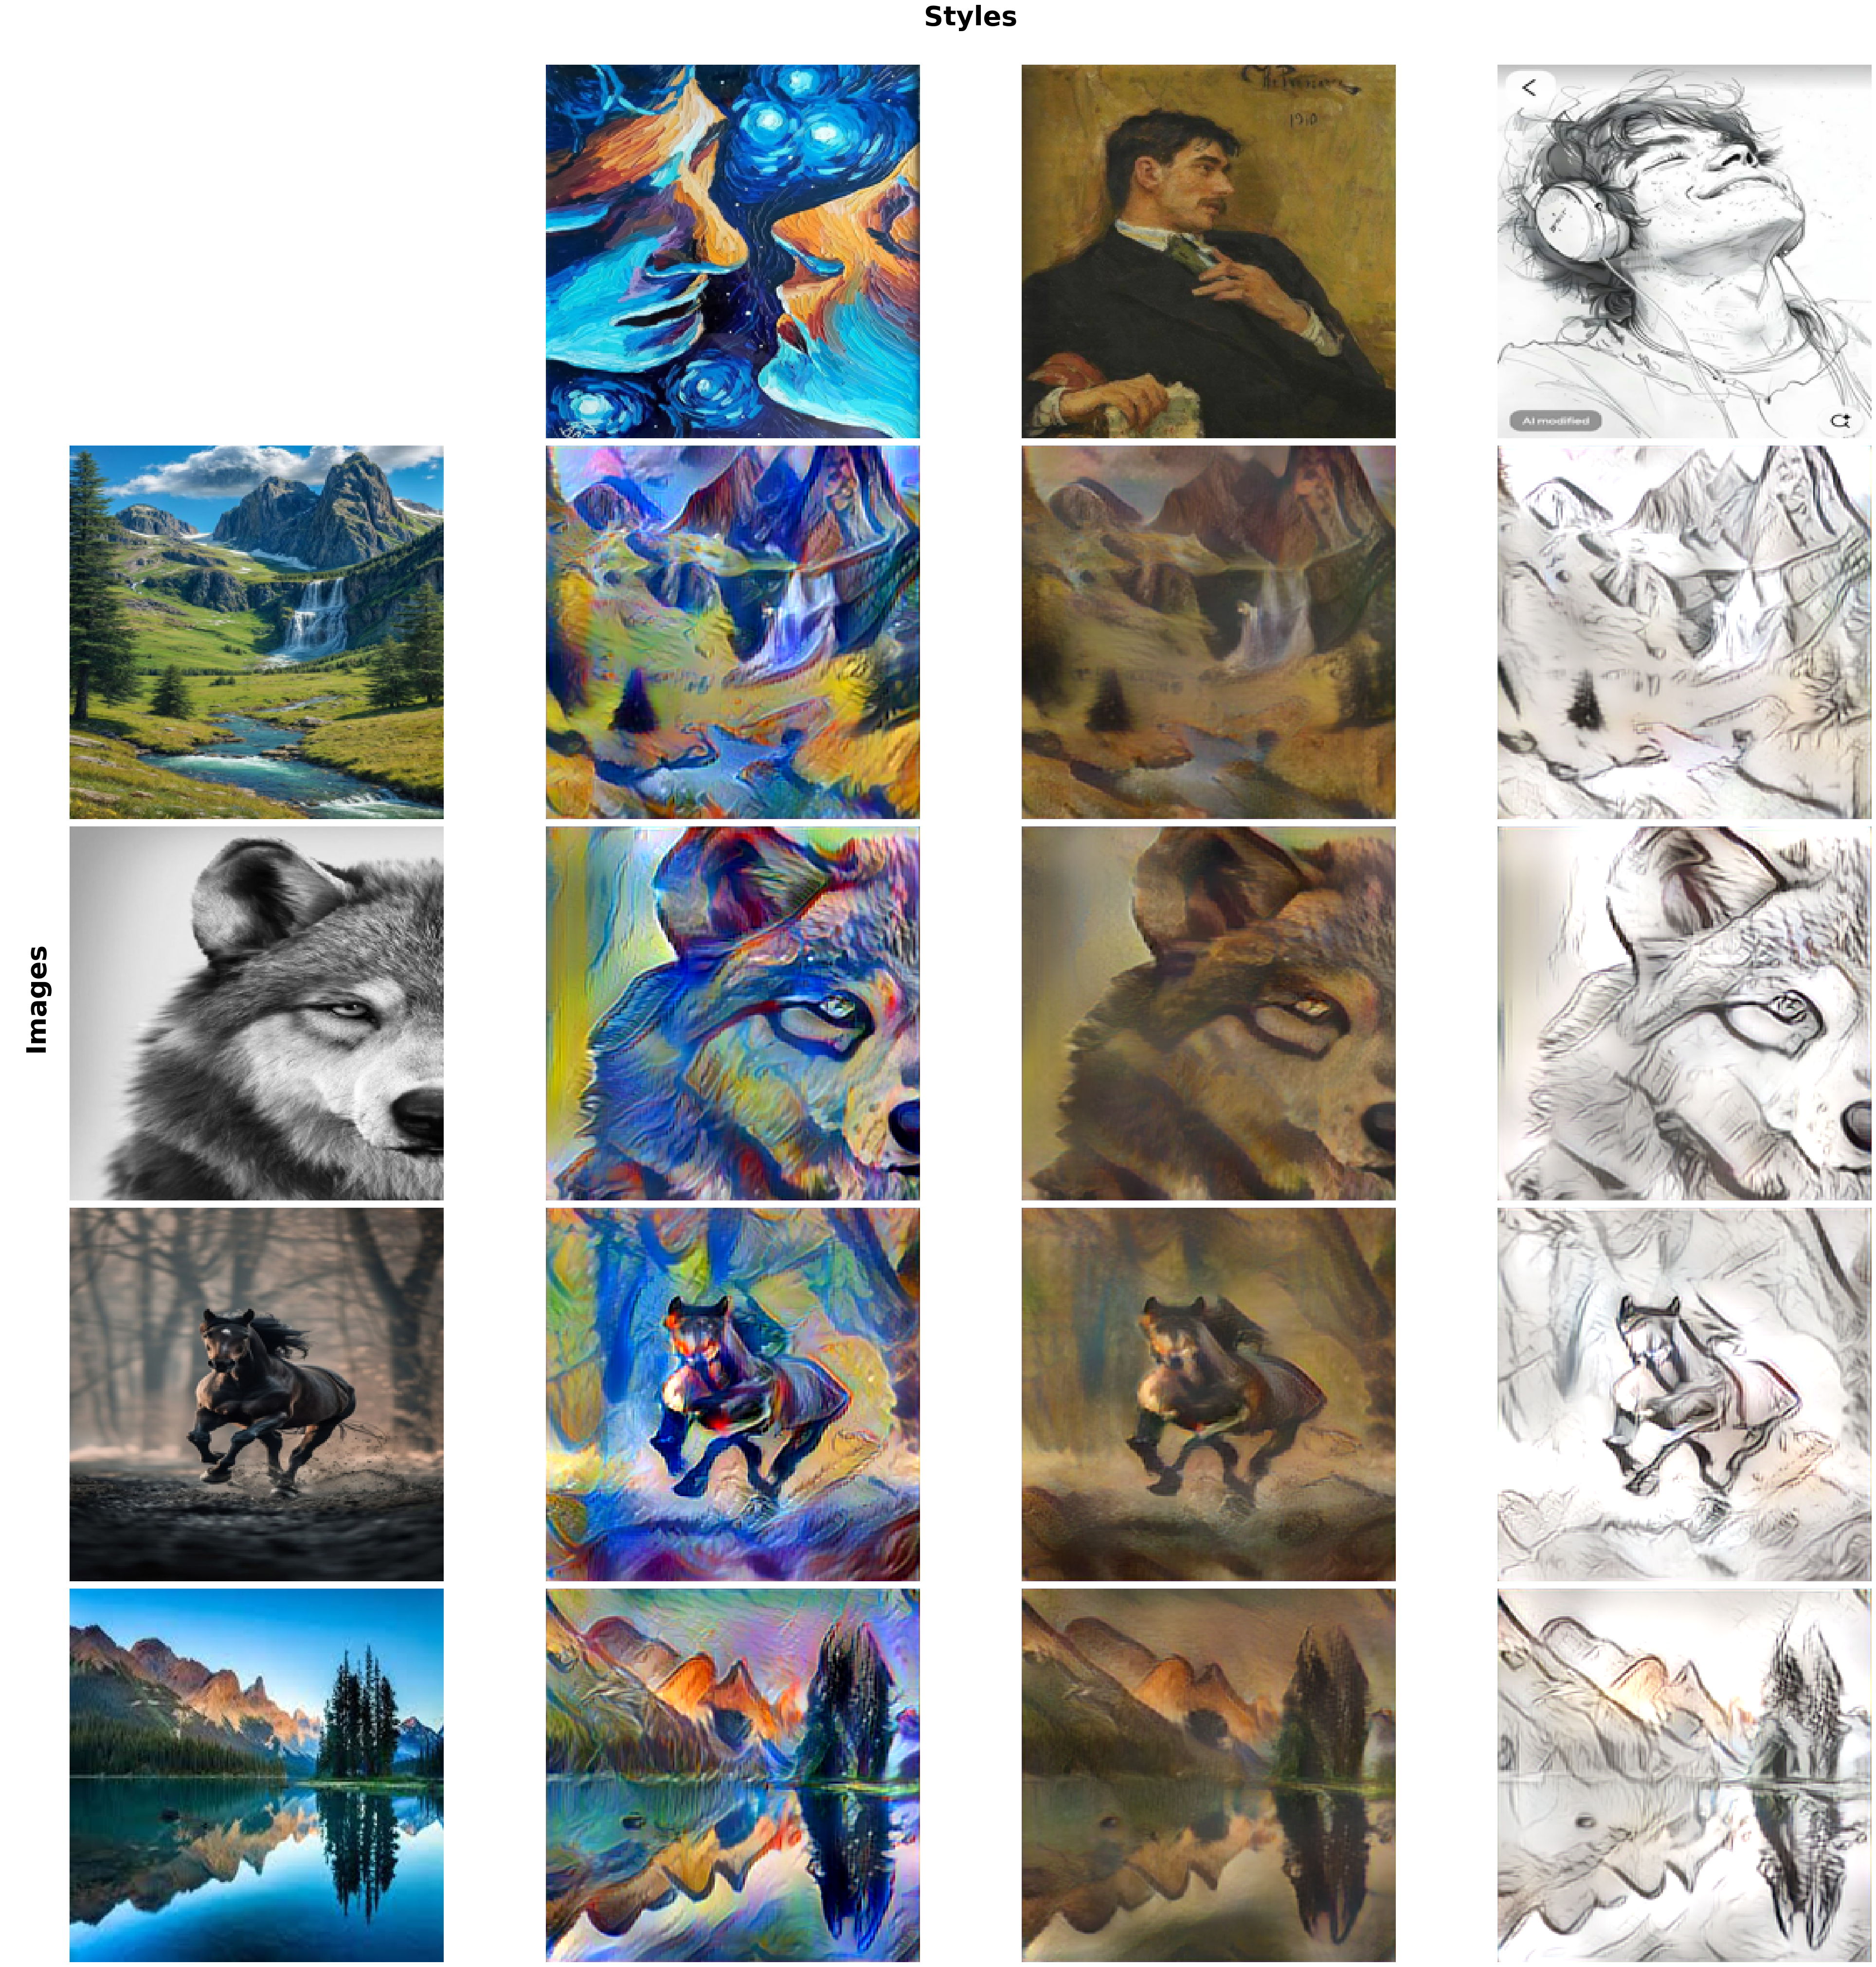

In [47]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

fig, axes = plt.subplots(len(imgs) + 1, len(styles) + 1, figsize=(40, 40))

# Add "Styles" header above the top row
fig.suptitle("Styles", fontsize=40, weight='bold', y=1.01)

# Add "Images" header in left column
fig.text(0.02, 0.5, "Images", fontsize=40, weight='bold', ha='center', rotation=90, va='center')

# Show headers (style images in top row)
for j, style_path in enumerate(styles):
    style_img = Image.open(style_path).convert("RGB")
    style_img = style_img.resize((224, 224))
    axes[0, j + 1].imshow(style_img)
    axes[0, j + 1].axis("off")

# Empty corner (top-left)
axes[0, 0].axis("off")

# Process each content image
for i, img_path in enumerate(imgs):
    img_pil = Image.open(img_path).convert("RGB")
    img_pil = img_pil.resize((224, 224))
    axes[i + 1, 0].imshow(img_pil)
    axes[i + 1, 0].axis("off")

    for j, style_path in enumerate(styles):
        img = transform_img(img_pil).unsqueeze(0)
        style = Image.open(style_path).convert("RGB")
        style = transform_img(style).unsqueeze(0)

        with torch.no_grad():
            generated = model(img, style)
            y_gen = generated["x_gen"]
            y_gen = denormalize(y_gen)
            y_gen = y_gen.permute(0, 2, 3, 1).cpu().squeeze()

        axes[i + 1, j + 1].imshow(y_gen)
        axes[i + 1, j + 1].axis("off")

plt.tight_layout()
plt.show()
